# Weighted Portfolio (prettier graphs)

On the first trading day of every month, rebalance portfolio to given percentages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbols = ['SPY', 'TLT', 'GLD']
weights = {'SPY': 0.50, 'TLT': 0.40, 'GLD': 0.10}
directions = {'SPY': pf.Direction.LONG, 'TLT': pf.Direction.LONG, 'GLD': pf.Direction.LONG}
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

use_cache = False

In [4]:
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, use_cache=use_cache)

In [5]:
# add calendar columns
ts = portfolio.calendar(ts)

In [6]:
ts, start = portfolio.finalize_timeseries(ts, start)

In [7]:
portfolio.init_trade_logs(ts, capital)

In [8]:
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)

    # rebalance on the first trading day of each month
    if row.first_dotm or end_flag:
        #portfolio.print_holdings(date, row)
        for symbol in portfolio.symbols:
            price = getattr(row, symbol + '_close')
            weight = 0 if end_flag else weights[symbol]
            direction = directions[symbol]
            portfolio.adjust_percent(date, price, weight, symbol, row, direction)
    # record daily balance
    portfolio.record_daily_balance(date, row)

In [9]:
rlog, tlog, dbal = portfolio.get_logs()

In [10]:
rlog.head()

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2004-12-01,0,85.96,58,entry,LONG,SPY
1,2004-12-01,1,51.02,78,entry,LONG,TLT
2,2004-12-01,2,45.38,22,entry,LONG,GLD
3,2005-01-03,3,52.57,1,exit,LONG,TLT
4,2005-01-03,4,43.02,1,entry,LONG,GLD


In [11]:
tlog.tail()

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
359,2021-01-04,157.17,2021-03-26,136.66,-20.51,-20.51,1,32459.82,LONG,TLT
360,2021-02-01,151.82,2021-03-26,136.66,-15.16,-60.63,4,32399.19,LONG,TLT
361,2021-02-01,174.23,2021-03-26,162.24,-11.99,-11.99,1,32387.20,LONG,GLD
362,2021-03-01,141.06,2021-03-26,136.66,-4.40,-35.20,8,32352.00,LONG,TLT
363,2021-03-01,161.53,2021-03-26,162.24,0.71,1.42,2,32353.42,LONG,GLD


In [12]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2021-03-22,45576.21,45576.21,45576.21,216,528.19,1.00,-
2021-03-23,45523.57,45523.57,45523.57,216,528.19,1.00,-
2021-03-24,45520.61,45520.61,45520.61,216,528.19,1.00,-
2021-03-25,45488.83,45488.83,45488.83,216,528.19,1.00,-
2021-03-26,42353.42,42353.42,42353.42,0,42353.42,1.00,X


In [13]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                  2004-11-18
end                                                    2021-03-26
beginning_balance                                           10000
ending_balance                                           42353.42
total_net_profit                                         32353.42
gross_profit                                             33798.88
gross_loss                                               -1445.46
profit_factor                                               23.38
return_on_initial_capital                                  323.53
annual_return_rate                                           9.23
trading_period                           16 years 4 months 8 days
pct_time_in_market                                          99.81
margin                                                          1
avg_leverage                                                 1.00
max_leverage                                                 1.00
min_levera

In [16]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

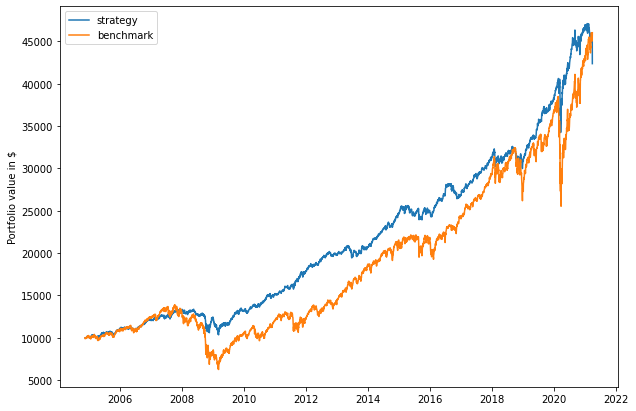

In [17]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

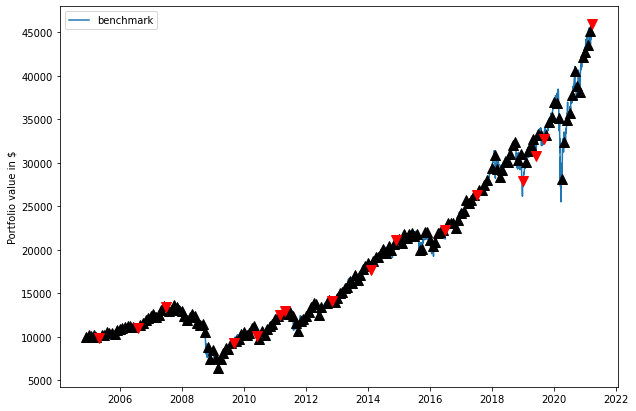

In [18]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

In [19]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$42,353.42","$46,003.86"
total_net_profit,"$32,353.42","$36,003.86"
gross_profit,"$33,798.88","$36,003.86"
gross_loss,"-$1,445.46",$0.00


,strategy,benchmark
annual_return_rate,9.23,9.78
max_closed_out_drawdown,-22.65,-54.91
annualized_return_over_max_drawdown,0.41,0.18
best_month,17.43,23.36
worst_month,-15.56,-30.93
sharpe_ratio,1.02,0.58
sortino_ratio,1.28,0.69
monthly_std,2.36,4.53
annual_std,8.23,15.55


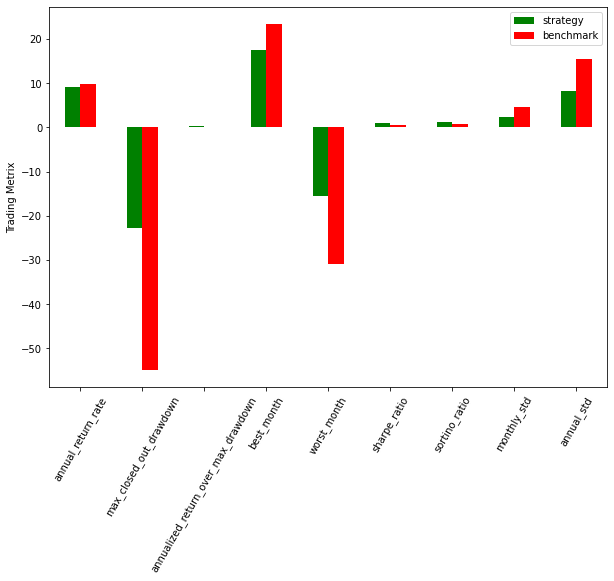

In [20]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df

In [21]:
returns = dbal['close']
returns.tail()

date
2021-03-22   45576.21
2021-03-23   45523.57
2021-03-24   45520.61
2021-03-25   45488.83
2021-03-26   42353.42
Name: close, dtype: float64

In [22]:
benchmark_returns = benchmark.dbal['close']
benchmark_returns.tail()

date
2021-03-22   45610.62
2021-03-23   45252.18
2021-03-24   45022.50
2021-03-25   45275.38
2021-03-26   46003.86
Name: close, dtype: float64

In [23]:
returns

date
2004-11-18   10000.00
2004-11-19   10000.00
2004-11-22   10000.00
2004-11-23   10000.00
2004-11-24   10000.00
               ...   
2021-03-22   45576.21
2021-03-23   45523.57
2021-03-24   45520.61
2021-03-25   45488.83
2021-03-26   42353.42
Name: close, Length: 4116, dtype: float64

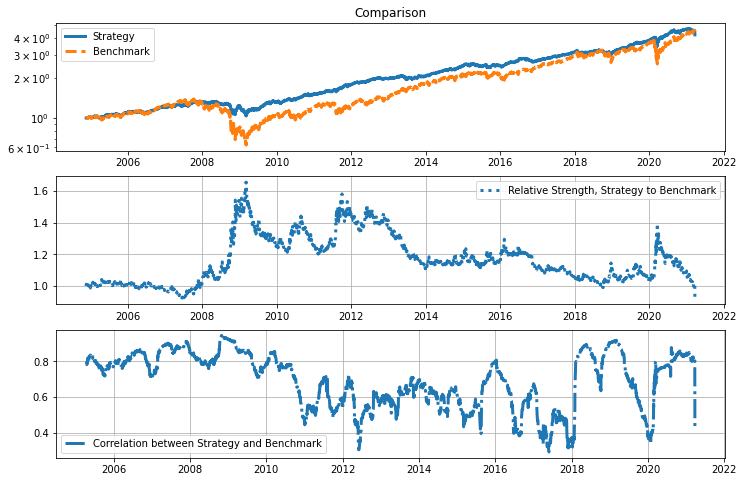

In [24]:
pf.prettier_graphs(returns, benchmark_returns, points_to_plot=5000)